In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#from pathlib import Path
import sys
import os
import argparse
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
sys.path.append('../')
import json
from pathlib import Path
from log import logger
import logging
#from lib.io.loadConfigs import *
import lib.io.loadConfigs as loadConfigs
import lib.io.readPollyRawData as readPollyRawData
import lib.interface.picassoProc as picassoProc
import lib.misc.helper as helper
import lib.misc.startscreen as startscreen
import lib.misc.json2nc_mapping as json2nc_mapping

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [4]:
## getting root dir of PicassoPy
root_dir0 = Path(os.path.abspath('')).resolve().parent
root_dir = helper.detect_path_type(root_dir0)

print(root_dir0)
print(root_dir)

## setting config files
picasso_default_config_file = Path(root_dir,'lib','config','pollynet_processing_chain_config.json')
print(picasso_default_config_file)
polly_default_config_file = Path(root_dir,'lib','config','polly_global_config.json')
print(polly_default_config_file)
#picasso_config_file = "/pollyhome/Bildermacher2/experimental/PicassoPy/config/pollynet_processing_chain_config_rsd2_24h_exp.json"



/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy
/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy
/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config.json
/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/polly_global_config.json


In [5]:
# for purpose of the notebook mimic the argparse interface
from types import SimpleNamespace
args = SimpleNamespace()

args.timestamp = '20230618'
args.device = 'arielle'

args.picasso_config_file = "/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config_interface.json"
args.level0_file_to_process = "../../../../localdata/coala/arielle_24h/2023_06_18_Sun_ARI_00_00_01.nc"

In [6]:
import pprint

In [7]:
## start_screen
startscreen.startscreen()

## loading configs as dicts
picasso_config_dict = loadConfigs.loadPicassoConfig(args.picasso_config_file,picasso_default_config_file)
pprint.pprint(picasso_config_dict)
polly_config_array = loadConfigs.readPollyNetConfigLinkTable(picasso_config_dict['pollynet_config_link_file'],timestamp=args.timestamp,device=args.device)
polly_config_file = str(polly_config_array['Config file'].to_string(index=False)).strip()
polly_device = str(polly_config_array['Instrument'].to_string(index=False)).strip()
polly_location = str(polly_config_array['Location'].to_string(index=False)).strip()
polly_asl = str(polly_config_array['asl.'].to_string(index=False)).strip()

output_path = Path(picasso_config_dict["fileinfo_new"]).parent

if polly_config_file:
    polly_config_file_fullname = Path(picasso_config_dict['polly_config_folder'],polly_config_file)
else:
    polly_config_file_fullname = polly_default_config_file

print("polly_config_file_fullname", polly_config_file_fullname)
print("polly_default_config_file", polly_default_config_file)

polly_config_dict = loadConfigs.loadPollyConfig(polly_config_file_fullname, polly_default_config_file)
## adding some information from pollynet_config_link_file (xlsx-file) to polly_config_dict
polly_config_dict['name'] = polly_device
polly_config_dict['site'] = polly_location
polly_config_dict['asl'] = polly_asl

2024-12-05 12:42:43,211 - INFO - picasso_default_config_file: /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config.json
2024-12-05 12:42:43,215 - INFO - picasso_config_file: /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config_interface.json
2024-12-05 12:42:43,221 - INFO - pollynet_config_link_file: /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config_links.xlsx


      ____  _                            ____           ___ ____ 
     / __ \(_)________ _______________  / __ \__  __   <  // __ \
    / /_/ / / ___/ __ `/ ___/ ___/ __ \/ /_/ / / / /   / // / / /
   / ____/ / /__/ /_/ (__  |__  ) /_/ / ____/ /_/ /   / // /_/ / 
  /_/   /_/\___/\__,_/____/____/\____/_/    \__, /   /_(_)____/  
                                           /____/                
{'MWRFolder': '/home/hatpro/data/nmy/data/level2/',
 'contact': 'Holger Baars <baars@tropos.de>',
 'defaultFile_folder': '/home/matlab/picasso-nb-interface/configs/pollyDefaults',
 'doneListFile': '/home/matlab/Pollynet_Processing_Chain/run_lists/done_filelist_playground.txt',
 'figDPI': 80,
 'fileinfo_new': '/home/matlab/Pollynet_Processing_Chain/run_lists/fileinfo_playground.txt',
 'flagDebugOutput': False,
 'flagDeleteData': False,
 'flagDeletePreOutputs': True,
 'flagEnableCaliResultsOutput': True,
 'flagEnableDataVisualization': False,
 'flagEnableDataVisualization24h': True,
 'flagEnableResu

2024-12-05 12:42:44,709 - INFO - polly_default_config_file: /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/polly_global_config.json
2024-12-05 12:42:44,715 - INFO - polly_config_file: /mnt/c/Users/radenz/dev/picasso-nb-interface/configs/pollyConfigs/arielle_config_20230101.json


polly_config_file_fullname /mnt/c/Users/radenz/dev/picasso-nb-interface/configs/pollyConfigs/arielle_config_20230101.json
polly_default_config_file /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/polly_global_config.json


In [8]:
rawfile_fullname = args.level0_file_to_process
print(rawfile_fullname)
rawfile = helper.detect_path_type(rawfile_fullname)

../../../../localdata/coala/arielle_24h/2023_06_18_Sun_ARI_00_00_01.nc


In [9]:
rawdata_dict = readPollyRawData.readPollyRawData(filename=rawfile)

## initate picasso-object from class PicassoProc
data_cube = picassoProc.PicassoProc(rawdata_dict,polly_config_dict,picasso_config_dict)


2024-12-05 12:42:47,968 - INFO - reading nc-file: ../../../../localdata/coala/arielle_24h/2023_06_18_Sun_ARI_00_00_01.nc


In [10]:
#print(data_cube.device)
#print(data_cube.location)
#print(data_cube.date)

## reset date if date in filename differs date within nc-file 
data_cube.reset_date_infile()

## checking for correct mshots
data_cube.check_for_correct_mshots()
#print(data_cube.filter_or_correct_false_mshots())

## setting channelTags
data_cube.setChannelTags()
#print(data_cube.polly_config_dict['channelTags'])
#print(data_cube.channel_dict)

## check for correct date in nc-file
data_cube.reset_date_infile()

## preprocessing
data_cube.preprocessing()
#print(data_cube.rawdata_dict.keys())
#print(data_cube.data_retrievals.keys())

2024-12-05 12:42:55,087 - INFO - date consistency-check... 
2024-12-05 12:42:55,092 - INFO - ... date in nc-file equals date of filename
2024-12-05 12:42:55,107 - INFO - ChannelLabels: ['FR-total-355 nm', 'FR-cross-355 nm', 'FR-387 nm', 'FR-407 nm', 'FR-total-532 nm', 'FR-cross-532 nm', 'FR-607 nm', 'FR-total-1064 nm', 'NR-total-532 nm', 'NR-607 nm', 'NR-total-355 nm', 'NR-387 nm']
2024-12-05 12:42:55,109 - INFO - date consistency-check... 
2024-12-05 12:42:55,110 - INFO - ... date in nc-file equals date of filename
2024-12-05 12:42:55,112 - INFO - starting data preprocessing...
2024-12-05 12:42:55,114 - INFO - ... time conversion
2024-12-05 12:42:55,132 - INFO - ... Deadtime-correction (Mode: 1)
2024-12-05 12:44:51,262 - INFO - ... removing background from signal
2024-12-05 12:44:56,383 - INFO - ... height bin calculations
2024-12-05 12:44:56,401 - INFO - ... mask bins with low SNR
2024-12-05 12:45:32,630 - INFO - ... mask for polarization calibration
2024-12-05 12:45:32,877 - INFO - 

In [11]:
print(data_cube.rawdata_dict.keys())

dict_keys(['filename', 'global_attributes', 'raw_signal', 'measurement_shots', 'measurement_time', 'depol_cal_angle', 'measurement_height_resolution', 'laser_rep_rate', 'laser_power', 'laser_flashlamp', 'location_height', 'location_coordinates', 'neutral_density_filter', 'if_center', 'if_fwhm', 'polstate', 'telescope', 'deadtime_polynomial', 'deadtime_polynomial_error', 'discr_level', 'pm_voltage', 'pinhole', 'zenithangle'])


In [12]:
print(data_cube.data_retrievals.keys())

dict_keys(['channel', 'PCR_cor', 'BG', 'height', 'alt', 'time', 'SNR', 'lowSNRMask', 'depol_cal_ang_p_time_start', 'depol_cal_ang_p_time_end', 'depol_cal_ang_n_time_start', 'depol_cal_ang_n_time_end', 'depCalMask', 'RCS'])


In [13]:
print(data_cube.channel_dict)

{0: 'FR-total-355 nm', 1: 'FR-cross-355 nm', 2: 'FR-387 nm', 3: 'FR-407 nm', 4: 'FR-total-532 nm', 5: 'FR-cross-532 nm', 6: 'FR-607 nm', 7: 'FR-total-1064 nm', 8: 'NR-total-532 nm', 9: 'NR-607 nm', 10: 'NR-total-355 nm', 11: 'NR-387 nm'}


In [14]:
#time = datetime.datetime.timestamp(datetime.datetime.now(datetime.timezone.utc))
print(data_cube.date)
data_cube.data_retrievals['time'][0], data_cube.data_retrievals['time'][-1] 

20230618


(1687039200, 1687125570)

In [15]:
data_cube.data_retrievals.keys()

dict_keys(['channel', 'PCR_cor', 'BG', 'height', 'alt', 'time', 'SNR', 'lowSNRMask', 'depol_cal_ang_p_time_start', 'depol_cal_ang_p_time_end', 'depol_cal_ang_n_time_start', 'depol_cal_ang_n_time_end', 'depCalMask', 'RCS'])

In [33]:
data_cube.polarizationCaliD90()

starting loadGHK
data_cube keys  dict_keys(['rawdata_dict', 'polly_config_dict', 'picasso_config_dict', 'device', 'location', 'date', 'num_of_channels', 'num_of_profiles', 'data_retrievals', 'channel_dict', 'flags'])
dict_keys(['flagCorrectFalseMShots', 'flagFilterFalseMShots', 'flagForceMeasTime', 'flagDTCor', 'flagSigTempCor', 'flagLCCalibration', 'flagDepolCali', 'flagWVCalibration', 'flagUsePreviousDepolCali', 'flagUsePreviousWVconst', 'flagUsePreviousLC', 'flagUseManualRefH', 'flagUseSameRefH', 'flagAutoscaleRCS', 'flagMolDepolCali', 'flagTransCor', 'flagUseTheoreticalMDR', 'MWRFolder', 'dataFileFormat', 'gdas1Site', 'meteorDataSource', 'meteo_folder', 'AERONETSite', 'max_height_bin', 'first_range_gate_indx', 'first_range_gate_height', 'deltaT', 'dtCorModeLabel', 'dtCorMode', 'dt', 'bgCorRangeIndx', 'mask_SNRmin', 'tempCorFunc', 'init_depAng', 'depol_cali_mode', 'depol_cal_time_fixed_p_start', 'depol_cal_time_fixed_p_end', 'depol_cal_time_fixed_m_start', 'depol_cal_time_fixed_m_en

In [13]:
import lib.io.readMeteo as readMeteo
import datetime

In [14]:
polly_config_dict['meteorDataSource'] = 'nc_cloudnet'
polly_config_dict['meteo_folder'] = '/mnt/c/Users/radenz/localdata/coala/model_ecmwf'
polly_config_dict['meteo_file'] = ".*/{0:%Y}/{0:%Y%m%d}.*.nc"

met = readMeteo.Meteo(polly_config_dict['meteorDataSource'], 
                      polly_config_dict['meteo_folder'],
                      polly_config_dict['meteo_file'])

# met.load(data_cube.data_retrievals['time'][0])
met.load(datetime.datetime.timestamp(datetime.datetime.strptime(data_cube.date, '%Y%m%d')),
         data_cube.data_retrievals['height'])

candidates  ['/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230616_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230617_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230618_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230619_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230620_neumayer_ecmwf.nc']
regex  re.compile('.*/2023/20230618.*.nc')
filename  ['/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230618_neumayer_ecmwf.nc']
<xarray.Dataset> Size: 417kB
Dimensions:                       (time: 25, level: 137, flux_level: 138,
                                   frequency: 2, soil_level: 4)
Coordinates:
  * time                          (time) datetime64[ns] 200B 2023-06-18 ... 2...
  * level                         (level) int16 274B 137 136 135 134 ... 4 3 2 1
  * flux_level                    (flux_level) int16 276B 138 137 136 ... 3 2 1
  * frequency

In [19]:
ds_dash = met.ds

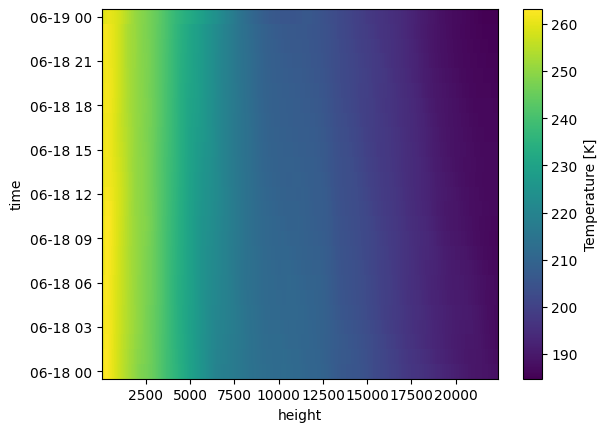

In [20]:

ds_dash.temperature.plot()

(-100.0, 1000.0)

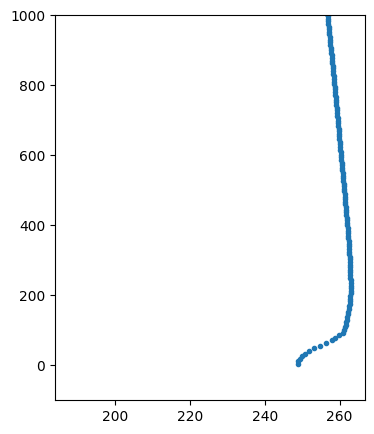

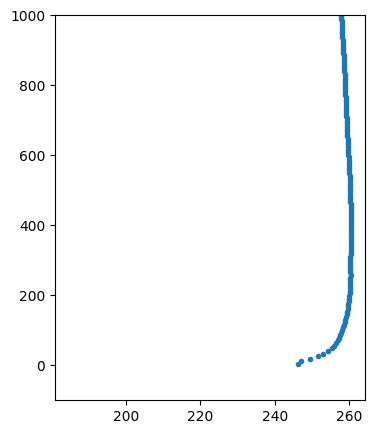

In [24]:
fig, ax = plt.subplots(figsize=(4,5))


ax.plot(ds_dash.isel(time=0)['temperature'], ds_dash.height, '.')

ax.set_ylim(-100, 1000)

fig, ax = plt.subplots(figsize=(4,5))

ax.plot(ds_dash.isel(time=-1)['temperature'], ds_dash.height, '.')

ax.set_ylim(-100, 1000)

In [93]:
import lib.misc.molecular as molecular

In [94]:

# interpolation/averaging should be straightforward with the xarray dataset
# for testing reasons just try with the first timestep
tprh = met.ds.isel(time=0)

# fig, ax = plt.subplots(figsize=(4,5))

# ax.plot(ds_dash.isel(time=0)['temperature'], tprh.height, '.')

mBsc355, mExt355 = molecular.rayleigh_scattering(
    355, tprh['pressure'].values/100, tprh['temperature'].values, 400, tprh['rh'].values*100)
mBsc387, mExt387 = molecular.rayleigh_scattering(
    387, tprh['pressure'].values/100, tprh['temperature'].values, 400, tprh['rh'].values*100)
mBsc407, mExt407 = molecular.rayleigh_scattering(
    407, tprh['pressure'].values/100, tprh['temperature'].values, 400, tprh['rh'].values*100)
mBsc532, mExt532 = molecular.rayleigh_scattering(
    532, tprh['pressure'].values/100, tprh['temperature'].values, 400, tprh['rh'].values*100)
mBsc607, mExt607 = molecular.rayleigh_scattering(
    607, tprh['pressure'].values/100, tprh['temperature'].values, 400, tprh['rh'].values*100)
mBsc1058, mExt1058 = molecular.rayleigh_scattering(
    1058, tprh['pressure'].values/100, tprh['temperature'].values, 400, tprh['rh'].values*100)
mBsc1064, mExt1064 = molecular.rayleigh_scattering(
    1064, tprh['pressure'].values/100, tprh['temperature'].values, 400, tprh['rh'].values*100)
number_density = molecular.number_density_at_pt(
    tprh['pressure'].values/100, tprh['temperature'].values, tprh['rh'].values, True);

# %% Calculate molecular scattering properties
# for iGrp = 1:size(clFreGrps, 1)
#         [mBsc355(iGrp,:), mExt355(iGrp,:)] = rayleigh_scattering(355,  data.pressure(iGrp, :), data.temperature(iGrp, :) + 273.17, 380, 70);
#         [mBsc387(iGrp,:), mExt387(iGrp,:)] = rayleigh_scattering(387,  data.pressure(iGrp, :), data.temperature(iGrp, :) + 273.17, 380, 70);
#         [mBsc407(iGrp,:), mExt407(iGrp,:)] = rayleigh_scattering(407,  data.pressure(iGrp, :), data.temperature(iGrp, :) + 273.17, 380, 70);
#         [mBsc532(iGrp,:), mExt532(iGrp,:)] = rayleigh_scattering(532,  data.pressure(iGrp, :), data.temperature(iGrp, :) + 273.17, 380, 70);
#         [mBsc607(iGrp,:), mExt607(iGrp,:)] = rayleigh_scattering(607,  data.pressure(iGrp, :), data.temperature(iGrp, :) + 273.17, 380, 70);
#         [mBsc1058(iGrp,:), mExt1058(iGrp,:)] = rayleigh_scattering(1058,  data.pressure(iGrp, :), data.temperature(iGrp, :) + 273.17, 380, 70);
#         [mBsc1064(iGrp,:), mExt1064(iGrp,:)] = rayleigh_scattering(1064,  data.pressure(iGrp, :), data.temperature(iGrp, :) + 273.17, 380, 70);
#         number_density(iGrp,:) = number_density_at_pt(data.pressure(iGrp, :), data.temperature(iGrp, :)+ 273.17, 70, true);
# end



['height', 'number_density', 'mBsc355', 'mExt355', 'mBsc387', 'mExt387', 'mBsc407', 'mExt407', 'mBsc532', 'mExt532', 'mBsc607', 'mExt607', 'mBsc1064', 'mExt1064']


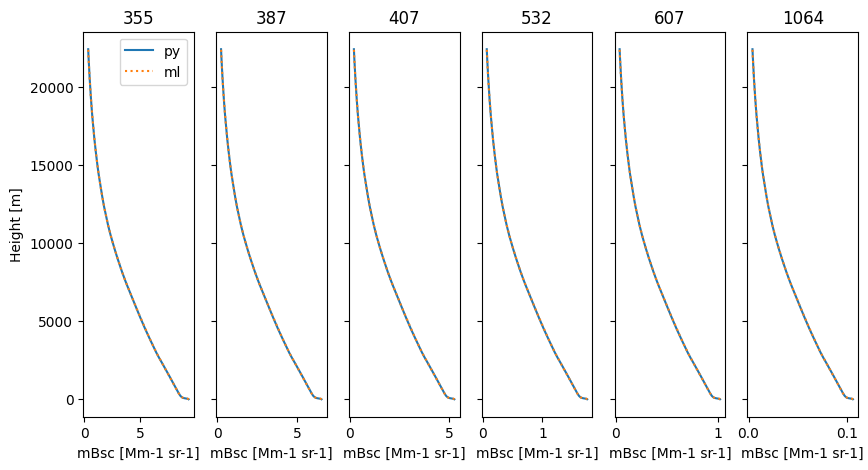

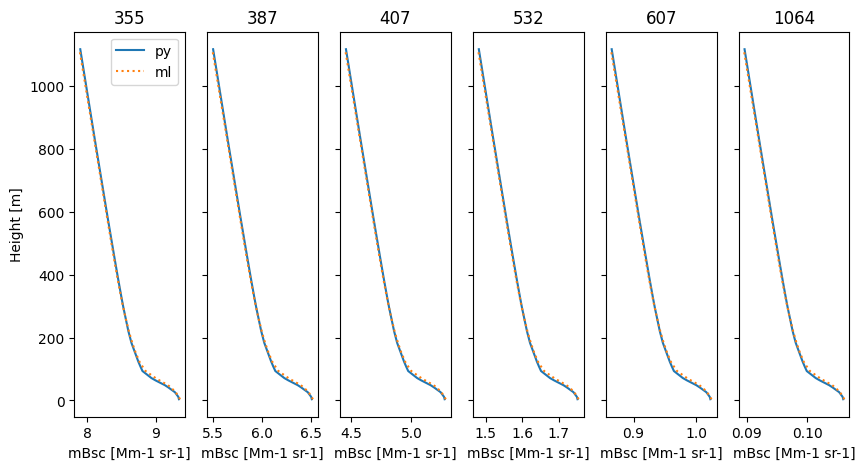

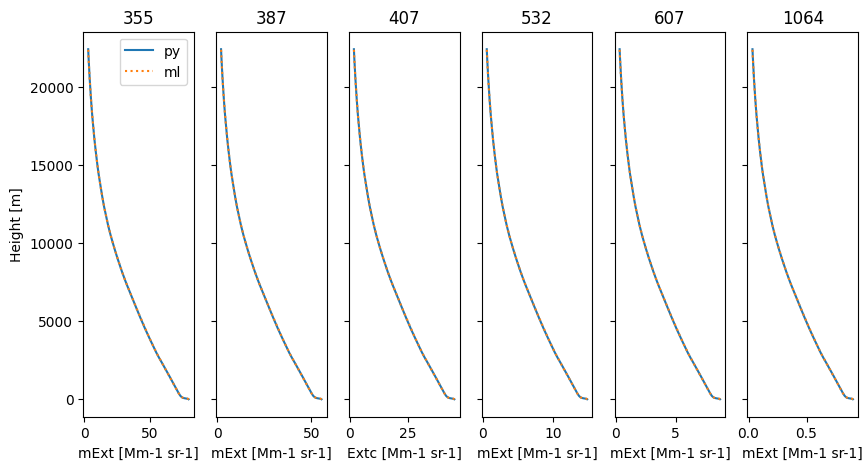

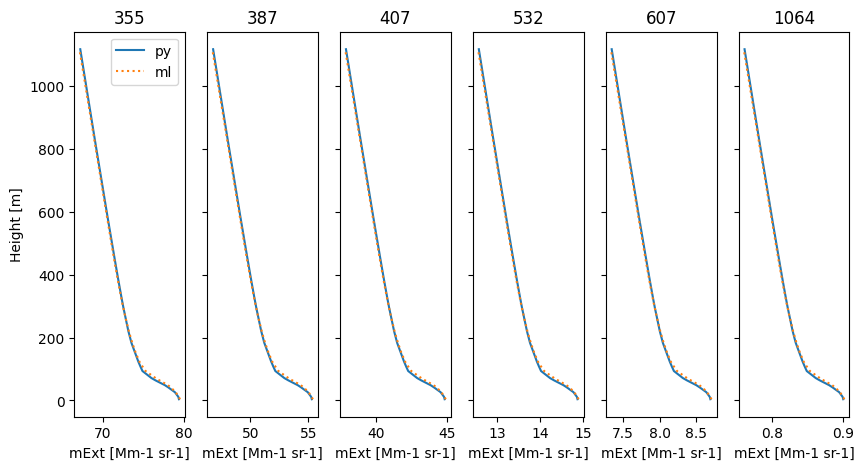

In [95]:
m_reference = np.load('20230618_0000_rayleigh_cal_matlab.npz')

print(m_reference.files)

icld=1

# print(m_reference['height'])
fig, ax = plt.subplots(1,6 ,figsize=(10,5), sharey=True)
ax[0].plot(mBsc355*1e6, tprh.height, '-', label='py')
ax[0].plot(m_reference['mBsc355'][icld,:]*1e6, m_reference['height'], ':', label='ml')
ax[0].set_xlabel('mBsc [Mm-1 sr-1]')
ax[0].set_ylabel('Height [m]')
ax[0].legend()
ax[0].set_title('355')

ax[1].plot(mBsc387*1e6, tprh.height, '-')
ax[1].plot(m_reference['mBsc387'][icld,:]*1e6, m_reference['height'], ':')
ax[1].set_xlabel('mBsc [Mm-1 sr-1]')
ax[1].set_title('387')

ax[2].plot(mBsc407*1e6, tprh.height, '-')
ax[2].plot(m_reference['mBsc407'][icld,:]*1e6, m_reference['height'], ':')
ax[2].set_xlabel('mBsc [Mm-1 sr-1]')
ax[2].set_title('407')

ax[3].plot(mBsc532*1e6, tprh.height, '-')
ax[3].plot(m_reference['mBsc532'][icld,:]*1e6, m_reference['height'], ':')
ax[3].set_xlabel('mBsc [Mm-1 sr-1]')
ax[3].set_title('532')

ax[4].plot(mBsc607*1e6, tprh.height, '-')
ax[4].plot(m_reference['mBsc607'][icld,:]*1e6, m_reference['height'], ':')
ax[4].set_xlabel('mBsc [Mm-1 sr-1]')
ax[4].set_title('607')

ax[5].plot(mBsc1064*1e6, tprh.height, '-')
ax[5].plot(m_reference['mBsc1064'][icld,:]*1e6, m_reference['height'], ':')
ax[5].set_xlabel('mBsc [Mm-1 sr-1]')
ax[5].set_title('1064')

fig.savefig('mBsc_full_height.png')

fig, ax = plt.subplots(1,6 ,figsize=(10,5), sharey=True)
ax[0].plot(mBsc355[:150]*1e6, tprh.height[:150], '-', label='py')
ax[0].plot(m_reference['mBsc355'][icld,:150]*1e6, m_reference['height'][:150], ':', label='ml')
ax[0].set_xlabel('mBsc [Mm-1 sr-1]')
ax[0].set_ylabel('Height [m]')
ax[0].legend()
ax[0].set_title('355')

ax[1].plot(mBsc387[:150]*1e6, tprh.height[:150], '-')
ax[1].plot(m_reference['mBsc387'][icld,:150]*1e6, m_reference['height'][:150], ':')
ax[1].set_xlabel('mBsc [Mm-1 sr-1]')
ax[1].set_title('387')

ax[2].plot(mBsc407[:150]*1e6, tprh.height[:150], '-')
ax[2].plot(m_reference['mBsc407'][icld,:150]*1e6, m_reference['height'][:150], ':')
ax[2].set_xlabel('mBsc [Mm-1 sr-1]')
ax[2].set_title('407')

ax[3].plot(mBsc532[:150]*1e6, tprh.height[:150], '-')
ax[3].plot(m_reference['mBsc532'][icld,:150]*1e6, m_reference['height'][:150], ':')
ax[3].set_xlabel('mBsc [Mm-1 sr-1]')
ax[3].set_title('532')

ax[4].plot(mBsc607[:150]*1e6, tprh.height[:150], '-')
ax[4].plot(m_reference['mBsc607'][icld,:150]*1e6, m_reference['height'][:150], ':')
ax[4].set_xlabel('mBsc [Mm-1 sr-1]')
ax[4].set_title('607')

ax[5].plot(mBsc1064[:150]*1e6, tprh.height[:150], '-')
ax[5].plot(m_reference['mBsc1064'][icld,:150]*1e6, m_reference['height'][:150], ':')
ax[5].set_xlabel('mBsc [Mm-1 sr-1]')
ax[5].set_title('1064')

fig.savefig('mBsc_lowest_height.png')

# =========================================================================================================

fig, ax = plt.subplots(1,6 ,figsize=(10,5), sharey=True)
ax[0].plot(mExt355*1e6, tprh.height, '-', label='py')
ax[0].plot(m_reference['mExt355'][icld,:]*1e6, m_reference['height'], ':', label='ml')
ax[0].set_xlabel('mExt [Mm-1 sr-1]')
ax[0].set_ylabel('Height [m]')
ax[0].legend()
ax[0].set_title('355')

ax[1].plot(mExt387*1e6, tprh.height, '-')
ax[1].plot(m_reference['mExt387'][icld,:]*1e6, m_reference['height'], ':')
ax[1].set_xlabel('mExt [Mm-1 sr-1]')
ax[1].set_title('387')

ax[2].plot(mExt407*1e6, tprh.height, '-')
ax[2].plot(m_reference['mExt407'][icld,:]*1e6, m_reference['height'], ':')
ax[2].set_xlabel('Extc [Mm-1 sr-1]')
ax[2].set_title('407')

ax[3].plot(mExt532*1e6, tprh.height, '-')
ax[3].plot(m_reference['mExt532'][icld,:]*1e6, m_reference['height'], ':')
ax[3].set_xlabel('mExt [Mm-1 sr-1]')
ax[3].set_title('532')

ax[4].plot(mExt607*1e6, tprh.height, '-')
ax[4].plot(m_reference['mExt607'][icld,:]*1e6, m_reference['height'], ':')
ax[4].set_xlabel('mExt [Mm-1 sr-1]')
ax[4].set_title('607')

ax[5].plot(mExt1064*1e6, tprh.height, '-')
ax[5].plot(m_reference['mExt1064'][icld,:]*1e6, m_reference['height'], ':')
ax[5].set_xlabel('mExt [Mm-1 sr-1]')
ax[5].set_title('1064')

fig.savefig('mExt_full_height.png')

fig, ax = plt.subplots(1,6 ,figsize=(10,5), sharey=True)
ax[0].plot(mExt355[:150]*1e6, tprh.height[:150], '-', label='py')
ax[0].plot(m_reference['mExt355'][icld,:150]*1e6, m_reference['height'][:150], ':', label='ml')
ax[0].set_xlabel('mExt [Mm-1 sr-1]')
ax[0].set_ylabel('Height [m]')
ax[0].legend()
ax[0].set_title('355')

ax[1].plot(mExt387[:150]*1e6, tprh.height[:150], '-')
ax[1].plot(m_reference['mExt387'][icld,:150]*1e6, m_reference['height'][:150], ':')
ax[1].set_xlabel('mExt [Mm-1 sr-1]')
ax[1].set_title('387')

ax[2].plot(mExt407[:150]*1e6, tprh.height[:150], '-')
ax[2].plot(m_reference['mExt407'][icld,:150]*1e6, m_reference['height'][:150], ':')
ax[2].set_xlabel('mExt [Mm-1 sr-1]')
ax[2].set_title('407')

ax[3].plot(mExt532[:150]*1e6, tprh.height[:150], '-')
ax[3].plot(m_reference['mExt532'][icld,:150]*1e6, m_reference['height'][:150], ':')
ax[3].set_xlabel('mExt [Mm-1 sr-1]')
ax[3].set_title('532')

ax[4].plot(mExt607[:150]*1e6, tprh.height[:150], '-')
ax[4].plot(m_reference['mExt607'][icld,:150]*1e6, m_reference['height'][:150], ':')
ax[4].set_xlabel('mExt [Mm-1 sr-1]')
ax[4].set_title('607')

ax[5].plot(mExt1064[:150]*1e6, tprh.height[:150], '-')
ax[5].plot(m_reference['mExt1064'][icld,:150]*1e6, m_reference['height'][:150], ':')
ax[5].set_xlabel('mExt [Mm-1 sr-1]')
ax[5].set_title('1064')

fig.savefig('mExt_lowest_height.png')


